# Introduction to connecting and Querying the Augur DB

## Connect to your database

Until the Operate First enviroment can connect to the DB, use config file to access. Do not push config file to Github repo

In [1]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import json
import os
import networkx as nx

with open("../comm_cage.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

### Retrieve Available Respositories

In [3]:
aval_repos = pd.DataFrame()
repo_query = salc.sql.text(f"""
             SET SCHEMA 'augur_data';
             SELECT a.rg_name,
                a.repo_group_id,
                b.repo_name,
                b.repo_id,
                b.forked_from,
                b.repo_archived,
                b.repo_git
            FROM
                repo_groups a,
                repo b
            WHERE
                a.repo_group_id = b.repo_group_id
            ORDER BY
                rg_name,
                repo_name;
    """)
aval_repos = pd.read_sql(repo_query, con=engine)
display(aval_repos)
aval_repos.dtypes

,rg_name,repo_group_id,repo_name,repo_id,forked_from,repo_archived,repo_git
0,3scale,25556,3scale,33134,Parent not available,0.0,https://github.com/3scale/3scale.github.io
1,3scale,25556,3scale-amp-openshift-templates,33126,Parent not available,0.0,https://github.com/3scale/3scale-amp-openshift...
2,3scale,25556,3scale-api-python,33130,3scale-qe/3scale-api-python,0.0,https://github.com/3scale/3scale-api-python
3,3scale,25556,3scale-api-ruby,33158,Parent not available,0.0,https://github.com/3scale/3scale-api-ruby
4,3scale,25556,3scale-go-client,33169,Parent not available,0.0,https://github.com/3scale/3scale-go-client
...,...,...,...,...,...,...,...
10956,zerodayz,25482,sosreport-operator,30872,andreaskaris/sosreport-operator,0.0,https://github.com/zerodayz/sosreport-operator
10957,zerodayz,25482,talos,30863,siderolabs/talos,0.0,https://github.com/zerodayz/talos
10958,zerodayz,25482,tests,30838,kata-containers/tests,0.0,https://github.com/zerodayz/tests
10959,zerodayz,25482,web,30839,openshifttips/web,0.0,https://github.com/zerodayz/web


rg_name           object
repo_group_id      int64
repo_name         object
repo_id            int64
forked_from       object
repo_archived    float64
repo_git          object
dtype: object

In [4]:
issue_contrib = pd.DataFrame()
repo_query = salc.sql.text(f"""
            SET SCHEMA 'augur_data';
            SELECT r.repo_id,
            r.repo_git,
            i.cntrb_id
            FROM
            repo r, issues i
             WHERE
            i.repo_id = r.repo_id
            limit 50000
    """)
issue_contrib = pd.read_sql(repo_query, con=engine)
issue_contrib.columns =['Repo ID', 'Git', 'Issue Authors']

display(issue_contrib)
issue_contrib.dtypes

,Repo ID,Git,Issue Authors
0,24441,https://github.com/operate-first/operate-first...,25438.0
1,24441,https://github.com/operate-first/operate-first...,25438.0
2,24441,https://github.com/operate-first/operate-first...,25438.0
3,24441,https://github.com/operate-first/operate-first...,25438.0
4,24441,https://github.com/operate-first/operate-first...,25449.0
...,...,...,...
49995,25759,https://github.com/eclipse/lemminx,NaN
49996,25759,https://github.com/eclipse/lemminx,NaN
49997,25759,https://github.com/eclipse/lemminx,NaN
49998,25759,https://github.com/eclipse/lemminx,NaN


Repo ID            int64
Git               object
Issue Authors    float64
dtype: object

In [5]:
issue_contrib.nunique()

Repo ID          216
Git              216
Issue Authors    918
dtype: int64

In [6]:
pr_contrib = pd.DataFrame()
repo_query = salc.sql.text(f"""
            SET SCHEMA 'augur_data';
            SELECT r.repo_id,
            r.repo_git,
            prm.cntrb_id
            FROM
            repo r, pull_request_meta prm 
             WHERE
            prm.repo_id = r.repo_id
            limit 50000
    """)
pr_contrib = pd.read_sql(repo_query, con=engine)
pr_contrib.columns =['Repo ID', 'Git', 'PR Creators']

display(pr_contrib)
pr_contrib.dtypes

,Repo ID,Git,PR Creators
0,27458,https://github.com/operate-first/continuous-de...,25443
1,27458,https://github.com/operate-first/continuous-de...,25465
2,27458,https://github.com/operate-first/continuous-de...,25444
3,27458,https://github.com/operate-first/continuous-de...,25465
4,27458,https://github.com/operate-first/continuous-de...,25433
...,...,...,...
49995,28335,https://github.com/ansible/ansible-modules-core,91339
49996,28335,https://github.com/ansible/ansible-modules-core,58062
49997,32524,https://github.com/openshift/test-pull-requests,2204263
49998,32524,https://github.com/openshift/test-pull-requests,2204295


Repo ID         int64
Git            object
PR Creators     int64
dtype: object

In [7]:
pr_contrib.nunique()

Repo ID         284
Git             284
PR Creators    2054
dtype: int64

In [8]:
prr_contrib = pd.DataFrame()
repo_query = salc.sql.text(f"""
            SET SCHEMA 'augur_data';
            SELECT r.repo_id,
            r.repo_git,
            prr.cntrb_id
            FROM
            repo r, pull_request_reviews prr
             WHERE
            prr.repo_id = r.repo_id
            limit 50000
    """)
prr_contrib = pd.read_sql(repo_query, con=engine)
prr_contrib.columns =['Repo ID', 'Git', 'PR Reviewers']

display(prr_contrib)
prr_contrib.dtypes

,Repo ID,Git,PR Reviewers
0,27458,https://github.com/operate-first/continuous-de...,25443
1,27458,https://github.com/operate-first/continuous-de...,25443
2,27458,https://github.com/operate-first/continuous-de...,25444
3,27458,https://github.com/operate-first/continuous-de...,25444
4,27458,https://github.com/operate-first/continuous-de...,25446
...,...,...,...
26800,28308,https://github.com/ansible/lightbulb,58328
26801,28308,https://github.com/ansible/lightbulb,58179
26802,28308,https://github.com/ansible/lightbulb,58059
26803,28308,https://github.com/ansible/lightbulb,58232


Repo ID          int64
Git             object
PR Reviewers     int64
dtype: object

In [9]:
prr_contrib.nunique()

Repo ID         191
Git             191
PR Reviewers    961
dtype: int64

In [10]:
commit_contrib = pd.DataFrame()
repo_query = salc.sql.text(f"""
            SET SCHEMA 'augur_data';
            SELECT r.repo_id,
            r.repo_git,
            ca.cntrb_id
            FROM
            repo r, commits c, contributors_aliases ca
             WHERE
            c.repo_id = r.repo_id and
            c.cmt_committer_email = ca.alias_email
            limit 50000
    """)
commit_contrib = pd.read_sql(repo_query, con=engine)
commit_contrib.columns =['Repo ID', 'Git', 'Commit Creators']

display(commit_contrib)
commit_contrib.dtypes

,Repo ID,Git,Commit Creators
0,26835,https://github.com/linux-audit/audit-kernel,32680
1,26835,https://github.com/linux-audit/audit-kernel,32680
2,27938,https://github.com/coreos/linux-deprecated,32680
3,27938,https://github.com/coreos/linux-deprecated,32680
4,27938,https://github.com/coreos/linux-deprecated,32680
...,...,...,...
49995,33378,https://github.com/oracle/dtrace-linux-kernel,30918
49996,33378,https://github.com/oracle/dtrace-linux-kernel,30918
49997,33378,https://github.com/oracle/dtrace-linux-kernel,30918
49998,33378,https://github.com/oracle/dtrace-linux-kernel,30918


Repo ID             int64
Git                object
Commit Creators     int64
dtype: object

In [11]:
commit_contrib.nunique()

Repo ID            83
Git                83
Commit Creators    42
dtype: int64

In [85]:
df_all_new = pd.DataFrame()

In [86]:
df_all_new = pd.merge(commit_contrib, issue_contrib, on=['Repo ID','Git'], how='outer')

In [87]:
df_all_new.nunique()

Repo ID            297
Git                297
Commit Creators     42
Issue Authors      918
dtype: int64

In [88]:
df_all_new = pd.merge(df_all_new, pr_contrib, on=['Repo ID', 'Git'], how='outer')

In [89]:
df_all_new.nunique()

Repo ID             572
Git                 572
Commit Creators      42
Issue Authors       918
PR Creators        2054
dtype: int64

In [90]:
df_all_new = pd.merge(df_all_new, prr_contrib, on=['Repo ID', 'Git'], how='outer')

In [91]:
df_all_new.nunique()

Repo ID             572
Git                 572
Commit Creators      42
Issue Authors       918
PR Creators        2054
PR Reviewers        961
dtype: int64

In [92]:
df_all_new.head()

,Repo ID,Git,Commit Creators,Issue Authors,PR Creators,PR Reviewers
0,26835,https://github.com/linux-audit/audit-kernel,32680.0,NaN,NaN,NaN
1,26835,https://github.com/linux-audit/audit-kernel,32680.0,NaN,NaN,NaN
2,26835,https://github.com/linux-audit/audit-kernel,30918.0,NaN,NaN,NaN
3,26835,https://github.com/linux-audit/audit-kernel,30918.0,NaN,NaN,NaN
4,26835,https://github.com/linux-audit/audit-kernel,30918.0,NaN,NaN,NaN


In [93]:
df_all_new = df_all_new[0:10000]

In [94]:
df = df_all_new.groupby(['Repo ID', 'Commit Creators']).size().unstack(fill_value=0)

In [95]:
df.head()

Commit Creators,29297.0,30918.0,32680.0
Repo ID,,,
26835,20,3928,4646
27938,0,663,743


In [96]:
df.columns

Float64Index([29297.0, 30918.0, 32680.0], dtype='float64', name='Commit Creators')

In [97]:
df = df.reset_index()

In [98]:
df.head()

Commit Creators,Repo ID,29297.0,30918.0,32680.0
0,26835,20,3928,4646
1,27938,0,663,743


In [113]:
df_melted = df.melt(
    ['Repo ID'],
    var_name = 'Contributor',value_name='number')

In [114]:
df_melted

,Repo ID,Contributor,number
0,26835,29297.0,20
1,27938,29297.0,0
2,26835,30918.0,3928
3,27938,30918.0,663
4,26835,32680.0,4646
5,27938,32680.0,743


In [115]:
Repo_id = df_melted['Repo ID'].to_list()
Repo_id

[26835, 27938, 26835, 27938, 26835, 27938]

In [116]:
contributor_id = df_melted['Contributor'].to_list()
contributor_id

[29297.0, 29297.0, 30918.0, 30918.0, 32680.0, 32680.0]

In [121]:
G = nx.from_pandas_edgelist(df_melted, 
                            source='Repo ID',
                            target='Contributor',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [126]:
nodes = G.nodes()
nodes

NodeView((26835, 29297.0, 27938, 30918.0, 32680.0))

In [133]:
nodes = list(nodes)
nodes

[26835, 29297.0, 27938, 30918.0, 32680.0]

In [135]:
colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]
colors

['blue', 'yellow', 'blue', 'yellow', 'yellow']

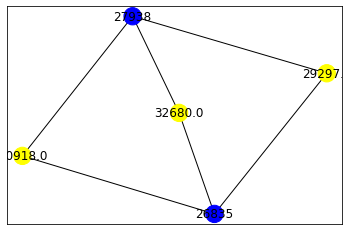

In [136]:
nx.draw_networkx(G, node_color=colors)

In [137]:
print(nx.info(G))

Name: 
Type: MultiGraph
Number of nodes: 5
Number of edges: 6
Average degree:   2.4000
